<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多値分類ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sma

#### 使用するデータセット

今回は、アヤメの品種データセットを使って、
花の品種予測を行います。

（参考サイト：[こちら](https://biotech-lab.org/articles/1408#i)）

## 0.モデル作成の手順

モデル作成を行うまでは、以下のような一連の手順を踏むと良いようです。

1. 問題を定義する<small>（何を知ればよいかを決める）</small>
2. データを入手する<small>（データを入手する）</small>
3. データを確認する<small>（実際にデータを確認・分析して項目同士の関係性や影響の有りそうな項目を見つける）</small>
4. データを整備する<small>（確認した結果、整備すべきものを整備する）</small>
4. 学習用・テスト用データに分割する<small>（モデル作成後に精度を検証するためデータ全体を分割しておきテスト用データを確保する）</small>
5. モデルを構築する<small>（適切な手法を選択しモデルを作成する）</small>
6. モデルを評価する<small>（退避させておいたテスト用データを作成したモデルに読み込ませて結果が正しく出るか精度を確認する）</small>

## 1.問題を定義する

今回から取り組む問題を整理すると、以下のようになります。

> <font color=blue>花びらやがく片の情報から、"アヤメ"の品種を分類する</font>



##2.データを用意する

### 2-1.データを入手する


今回は、scikit-learnのサンプルデータセットを利用します。

scikit-learnが持っているほかのサンプルデータについては、[こちら](https://zenn.dev/nekoallergy/articles/scikit-learn-datasets#%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E7%A8%AE%E9%A1%9E) の記事を参照してください。  
なお、2023年10月現在のscikit-learnのバージョン`1.2.2`では、  
ボストンのデータセットが使えなくなっています。

In [ ]:
import sklearn

print(sklearn.__version__)

1.2.2


まずは次のようにScikit-learnのデータセットをインポートします。

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

print(iris.data[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


まずはこのデータセットの解説を見てみましょう。

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

上の解説から、以下のことが分かります。

- データが150個ある：「Number of Instances: 150」
- 4種類のデータがある：「Number of Attributes: 4 numeric」
- 4つのデータがある：「Attribute Information」  
  - sepal length（がく片の長さ）:「sepal length in cm」
  - sepal width（がく片の幅）:「sepal width in cm」
  - petal length（花びらの長さ）:「petal length in cm」
  - petal width（花びらの幅）:「petal length in cm」
- 3種類の分類がある（それぞれ50個）：「class」
  - setosa（セトーサ、ヒオウギアヤメ）：Iris-Setosa
  - versicolour（ヴァーシカラー、ブルーフラッグ）：Iris-Versicolour
  - virginica（ヴァージニカ、ヴァージニカ）：Iris-Virginica

まずは扱いやすいように、Pandasのデータフレームにしていきましょう。

In [ ]:
# "iris.data"：データ
# "iris.feature_names"：列名

df = pd.DataFrame(iris.data, columns=iris.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


最終的に推測したいデータ「target」が入っていないので、追加していきます。

In [ ]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# "iris.target"：アヤメの種類のデータ
df["target"] = iris.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


"target"カラムの数字が何を意味しているか分かりづらいので、  
アヤメの種類名に置き換えましょう。

In [ ]:
df["target"][df["target"] == 0] = "setosa"
df["target"][df["target"] == 1] = "sersicolor"
df["target"][df["target"] == 2] = "virginica"

df.head()

<ipython-input-7-7b8e9e602f6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][df["target"] == 0] = "setosa"


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


`info`メソッドで全体のデータの概要を見てみましょう。

In [ ]:
# レコード件数、カラム数、欠損値の存在、データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## 3.データを確認する

まず、数値型のカラムの記述統計量を確認します。

- オプションで指定しなければ四分位までしか出力されない。
- 欠損値とはなっていなくても、"0"ばかりのデータなどを確認することができる。
- 99パーセンタイルと最大値を見ることで、異常値が確認しやすくなる。

In [ ]:
# 記述統計量を確認
df.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
10%,4.800000,2.500000,1.400000,0.200000
20%,5.000000,2.700000,1.500000,0.200000
30%,5.270000,2.800000,1.700000,0.400000
40%,5.600000,3.000000,3.900000,1.160000
50%,5.800000,3.000000,4.350000,1.300000
60%,6.100000,3.100000,4.640000,1.500000


次に、4つのデータとirisの種類にどんな関連性があるのか見るために、  
seabornのpairplotを描いてみてみましょう。

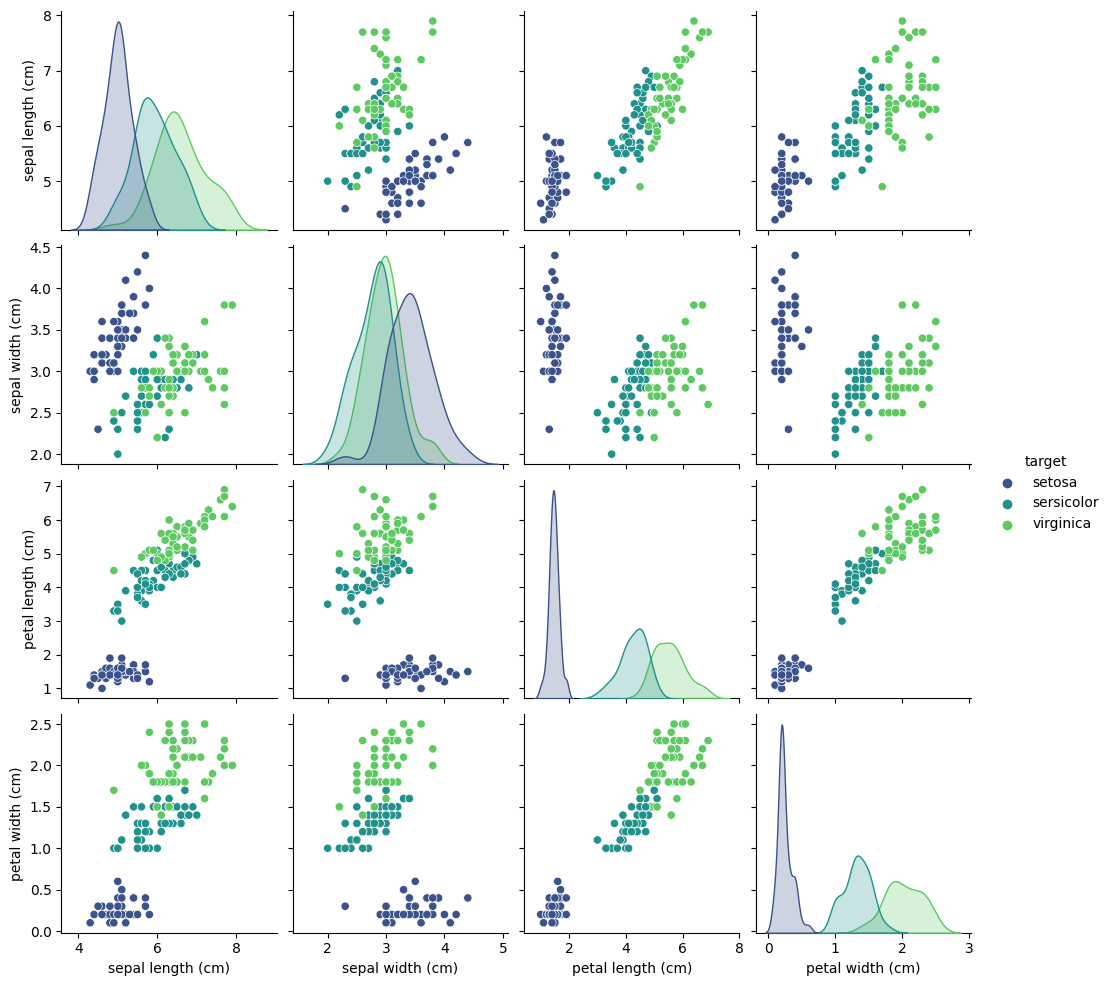

In [ ]:
# 'target' 列がクラスラベルを持つと仮定

sns.pairplot(df, hue="target", palette="viridis")

## 4.データを整備する

今回はかなりきれいなデータなので、データの整備は必要なさそうです。

上のpairplotを見たときに、"petal"（花びら）の2つのデータを見ると、  
かなり3つの種類が分けられていそうなので、この2つのデータに絞るという方向は考えられます。

## 5.学習用・テスト用データに分割する

hold-out法で、整備したデータを  
「学習用データ」と「テスト用データ」に分割します。

In [ ]:
# 目的変数に"target"、説明変数にそれ以外の6つのカラムを指定
X = df.drop('target', axis=1)
y = df['target']

# データを訓練データとテストデータに分ける
# データのばらつき具合を実データに合わせる
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


## 6.モデルを作成する

### 1.OvR


前処理とモデルを一つのオブジェクトとして扱うことができるpipelineを使って、  
いよいよ、まずはOvRを行っていきます。

In [ ]:
# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('model', LogisticRegression(penalty='none', multi_class='ovr'))  # OvRモデル
])
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(multi_class='ovr', penalty='none'))])

それぞれのラベルの分類結果を取得したいときは、  
**`.predict(X)`**を使います。

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred[:5]

array(['virginica', 'virginica', 'sersicolor', 'sersicolor', 'setosa'],
      dtype=object)

それぞれのラベルの確率$p(X)$を取得したいときは、  
**`.predict_proba(X)`**を使います。

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)
print(pipeline.named_steps['model'].classes_)  # クラスの値
print(pipeline.named_steps['model'].intercept_)  # 切片の値
print(y_pred_proba[:5])  # それぞれの出現確率

['sersicolor' 'setosa' 'virginica']
[ -0.98571007 -10.64026597 -16.89666882]
[[7.47211019e-02 3.60567451e-15 9.25278898e-01]
 [3.51209898e-01 3.40329557e-14 6.48790102e-01]
 [9.99893815e-01 1.63650373e-08 1.06169082e-04]
 [9.99874229e-01 3.82609788e-08 1.25732519e-04]
 [6.92563815e-02 9.30743618e-01 1.31737072e-23]]


係数の値を確認してみましょう。

In [ ]:
# OvRモデルの係数を取得
coef = pipeline.named_steps['model'].coef_[0]

# 係数をカラムと対応づけて表示
print(pd.Series(coef, index=X.columns))

sepal length (cm)   -0.933066
sepal width (cm)    -0.919758
petal length (cm)    3.234428
petal width (cm)    -2.257158
dtype: float64


学習(fit)時には、学習データにおける交差エントロピーを最小にするように、  
パラメータ$\theta$を求めています。

その後、テストデータを使って交差エントロピーを求めたい場合、  
`log_loss(y_test, y_pred_proba)`を使って求めることができます。

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)

5.355911933683511

### 2.多項ロジスティック回帰


次に、多項ロジスティック回帰を行っていきます。

In [ ]:
# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('model', LogisticRegression(penalty='none', multi_class='multinomial'))  # 多項ロジスティック回帰モデル
])
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(multi_class='multinomial',
                                    penalty='none'))])

それぞれのラベルの分類結果を取得したいときは、  
**`.predict(X)`**を使います。

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred[:5]

array(['virginica', 'virginica', 'sersicolor', 'sersicolor', 'setosa'],
      dtype=object)

それぞれのラベルの確率$p(X)$を取得したいときは、  
**`.predict_proba(X)`**を使います。

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)
print(pipeline.named_steps['model'].classes_)  # クラスの値
print(pipeline.named_steps['model'].intercept_)  # 切片の値
print(y_pred_proba[:5])  # それぞれの出現確率

['sersicolor' 'setosa' 'virginica']
[10.94083288 -4.98080632 -5.96002656]
[[1.23641774e-06 1.82752060e-28 9.99998764e-01]
 [1.04497505e-03 4.08501824e-27 9.98955025e-01]
 [9.99929716e-01 6.20625678e-16 7.02837489e-05]
 [9.99921704e-01 3.06687589e-14 7.82964440e-05]
 [1.84130848e-22 1.00000000e+00 2.57265235e-45]]


係数の値を確認してみましょう。

In [ ]:
# OvRモデルの係数を取得
coef = pipeline.named_steps['model'].coef_[0]

# 係数をカラムと対応づけて表示
print(pd.Series(coef, index=X.columns))

sepal length (cm)    3.840672
sepal width (cm)    -4.029669
petal length (cm)    0.947759
petal width (cm)     1.027583
dtype: float64


学習(fit)時には、学習データにおける交差エントロピーを最小にするように、  
パラメータ$\theta$を求めています。

その後、テストデータを使って交差エントロピーを求めたい場合、  
`log_loss(y_test, y_pred_proba)`を使って求めることができます。

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)

23.838725689682857

##  7.モデルを評価する

モデルの評価方法については、ここでは取り上げません。